# Downloading the Dataset

Uncomment the code below to download the CIFAR10 dataset.

In [11]:
# import torchvision.datasets as datasets

# # This command automatically downloads and loads the training data
# trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Loading Model

In [12]:
# Assuming your script successfully ran and stopped early:
FINAL_EPOCHS_TRAINED = 24 # You must look this up from your logs or filename!
MODEL_PATH = f'./saved_models/mobilenetv2_cifar10_baseline_scratch_{FINAL_EPOCHS_TRAINED}_epochs_best.pth'

In [13]:
import torch
import torch.nn as nn
from torchvision import models

# 1. Define the exact same architecture
def create_mobilenetv2_from_scratch(num_classes=10):
    model = models.mobilenet_v2(weights=None) 
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

# 2. Instantiate the model and load the weights
baseline_model = create_mobilenetv2_from_scratch(num_classes=10)

# Use map_location to load the model onto the CPU (if you don't need the GPU yet)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baseline_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# 3. Set the model to evaluation mode for inference or compression
baseline_model.to(device)
baseline_model.eval()

print("Model successfully loaded and ready for compression or inference.")

# 4. SHOW THE VARIOUS LAYERS IN THE MODEL
print("\n--- MobileNetV2 Named Modules ---")
# The infinite of the verb is 'show'.
for name, module in baseline_model.named_modules():
    # Only print layers that have parameters (Conv2d, BatchNorm, Linear) or are high-level containers
    if isinstance(module, (nn.Conv2d, nn.BatchNorm2d, nn.Linear, nn.Sequential)):
        # Calculate the number of parameters if they exist
        num_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        
        # Format the output to show structure (using depth for indentation)
        depth = name.count('.')
        indent = '  ' * depth
        
        if num_params > 0 or depth <= 2: # Print high-level blocks or layers with params
             print(f"{indent}[{name}] -> {module.__class__.__name__} ({num_params:,} params)")

Model successfully loaded and ready for compression or inference.

--- MobileNetV2 Named Modules ---
[features] -> Sequential (2,223,872 params)
  [features.0] -> Conv2dNormActivation (928 params)
    [features.0.0] -> Conv2d (864 params)
    [features.0.1] -> BatchNorm2d (64 params)
    [features.1.conv] -> Sequential (896 params)
      [features.1.conv.0] -> Conv2dNormActivation (352 params)
        [features.1.conv.0.0] -> Conv2d (288 params)
        [features.1.conv.0.1] -> BatchNorm2d (64 params)
      [features.1.conv.1] -> Conv2d (512 params)
      [features.1.conv.2] -> BatchNorm2d (32 params)
    [features.2.conv] -> Sequential (5,136 params)
      [features.2.conv.0] -> Conv2dNormActivation (1,728 params)
        [features.2.conv.0.0] -> Conv2d (1,536 params)
        [features.2.conv.0.1] -> BatchNorm2d (192 params)
      [features.2.conv.1] -> Conv2dNormActivation (1,056 params)
        [features.2.conv.1.0] -> Conv2d (864 params)
        [features.2.conv.1.1] -> BatchNorm2d

Training history successfully loaded.

Plot saved to: ./plots/baseline_history_plot.png


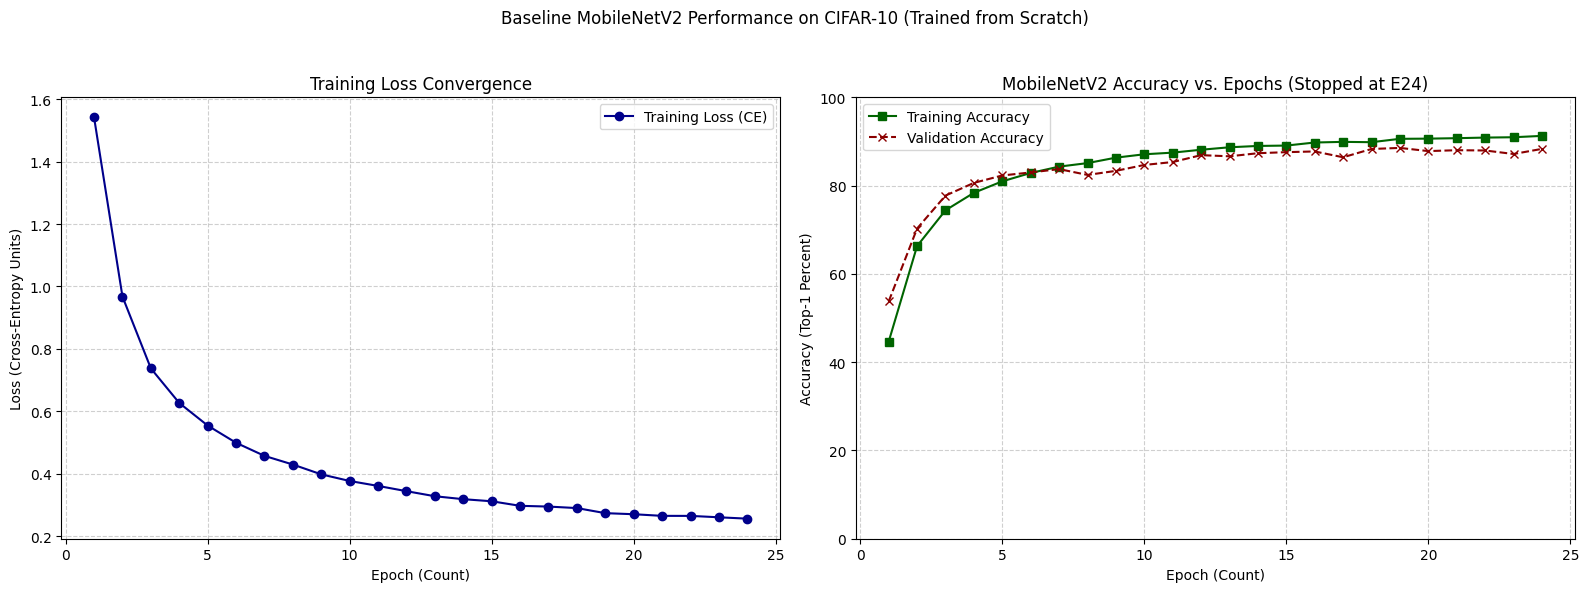

In [14]:
import pickle
import matplotlib.pyplot as plt
import os

# --- Configuration (MUST MATCH your saved file) ---
FINAL_EPOCHS_TRAINED = 24 # Must match the actual final epoch count
HISTORY_PATH = f'./saved_models/training_history_scratch_{FINAL_EPOCHS_TRAINED}_epochs.pkl'
# ----------------------------------------------------

# 1. Load the history dictionary
try:
    with open(HISTORY_PATH, 'rb') as f:
        history = pickle.load(f)
    print("Training history successfully loaded.")
except FileNotFoundError:
    print(f"Error: History file not found at {HISTORY_PATH}")
    exit()

# 2. Extract data and create plots
# Get the number of epochs actually trained (due to early stopping)
epochs = range(1, len(history['train_loss']) + 1)

# Per user request: Color-blind friendly, named axes, units, legend, title, and description.

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Loss Curve ---
ax1.plot(epochs, history['train_loss'], 
         label='Training Loss (CE)', 
         color='darkblue', 
         marker='o', 
         linestyle='-')
ax1.set_title('Training Loss Convergence')
ax1.set_xlabel('Epoch (Count)')
ax1.set_ylabel('Loss (Cross-Entropy Units)')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# --- Plot 2: Accuracy Curves ---
# Note: Using distinct markers and lines for color-challenged audience
ax2.plot(epochs, history['train_acc'], 
         label='Training Accuracy', 
         color='darkgreen', 
         marker='s', 
         linestyle='-')
ax2.plot(epochs, history['valid_acc'], 
         label='Validation Accuracy', 
         color='darkred', 
         marker='x', 
         linestyle='--')
ax2.set_title(f'MobileNetV2 Accuracy vs. Epochs (Stopped at E{len(epochs)})')
ax2.set_xlabel('Epoch (Count)')
ax2.set_ylabel('Accuracy (Top-1 Percent)')
ax2.set_ylim(0, 100) # Ensure y-axis is in Percent
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

# Main Title and Description (Required for self-explanatory plot)
fig.suptitle(f'Baseline MobileNetV2 Performance on CIFAR-10 (Trained from Scratch)')
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot for inclusion in your PDF report
PLOT_FILENAME = './plots/baseline_history_plot.png'
plt.savefig(PLOT_FILENAME)
print(f"\nPlot saved to: {PLOT_FILENAME}")
plt.show()

# Pruning

In [15]:
from prune import apply_pruning_to_model
from train_early_stopping import evaluate_model, load_and_prepare_data

In [16]:
BATCH_SIZE = 32      
INPUT_SIZE = 224      
VALID_SPLIT_RATIO = 0.1 # 10% of the training data will be used for validation
MANUAL_SEED = 42

In [17]:
train_loader, validation_loader, test_loader = load_and_prepare_data(
    INPUT_SIZE, BATCH_SIZE, VALID_SPLIT_RATIO, MANUAL_SEED
)

Calculating CIFAR-10 Mean and STD...
Calculated CIFAR-10 Mean: [0.4914000332355499, 0.4821583926677704, 0.4465310871601105]
Calculated CIFAR-10 STD: [0.2470323145389557, 0.24348513782024384, 0.2615879774093628]
Dataset Split: Training (45000 images), Validation (5000 images)


Below, we take the baseline model and analyze various levels of pruning to see the performance of the model after pruning.

In [18]:
# Configuration (Ensure these match your baseline run)
FINAL_EPOCHS_TRAINED = 24 # Use the actual number from your saved file
MODEL_PATH = f'./saved_models/mobilenetv2_cifar10_baseline_scratch_{FINAL_EPOCHS_TRAINED}_epochs_best.pth'
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
sparsity_targets = [0.20, 0.30, 0.40, 0.50]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)
# Plot these results to select the final sparsity target for your retraining loop.

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 20.0%) ---
Pruned Conv2d | Target: 20.0%, Actual: 20.14%, Threshold: 0.029031
Pruned Conv2d | Target: 20.0%, Actual: 20.12%, Threshold: 0.030375
Pruned Conv2d | Target: 20.0%, Actual: 20.05%, Threshold: 0.023833
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.020858
Pruned Conv2d | Target: 20.0%, Actual: 20.01%, Threshold: 0.023439
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.014395
Pruned Conv2d | Target: 20.0%, Actual: 20.06%, Threshold: 0.016491
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.021319
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.017504
Pruned Conv2d | Target: 20.0%, Actual: 20.06%, Threshold: 0.024930
Pruned Conv2d | Target: 20.0%, Actual: 20.01%, Threshold: 0.020952
Pruned Conv2d | Target: 20.0%, Actual: 20.00%, Threshold: 0.014143
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.022996
Pruned Conv2d | Target: 20.0%, 

From the above cell, we can see that we're able to prune 20% of the weights without significant loss in accuracy while not retraining the model.

We will however choose to prune by sparsity of 40% and then tune the model to observe the results using the script ```fine_tune.py```.

Upon tuning `mobilenetv2_cifar10_baseline_scratch_24_epochs_best.pth`, after 40% sparsifying, we obtain a an accuracy of about 92% on the tuned model stored as `mobilenetv2_pruned_40pc_39epochs_best.pth`

Now, we will try to see the effects of further pruning this new model to determine how much we can prune before we have to fine tune again.

In [19]:
# Configuration (Ensure these match your baseline run)
MODEL_PATH = f'./saved_models/mobilenetv2_pruned_40pc_39epochs_best.pth'
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
sparsity_targets = [0.20, 0.30, 0.40, 0.50, 0.60]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)
# Plot these results to select the final sparsity target for your retraining loop.

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 20.0%) ---
Pruned Conv2d | Target: 20.0%, Actual: 20.14%, Threshold: 0.001066
Pruned Conv2d | Target: 20.0%, Actual: 20.12%, Threshold: 0.001747
Pruned Conv2d | Target: 20.0%, Actual: 20.05%, Threshold: 0.002336
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.002360
Pruned Conv2d | Target: 20.0%, Actual: 20.01%, Threshold: 0.001565
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.001694
Pruned Conv2d | Target: 20.0%, Actual: 20.06%, Threshold: 0.002632
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.001008
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.002594
Pruned Conv2d | Target: 20.0%, Actual: 20.06%, Threshold: 0.003760
Pruned Conv2d | Target: 20.0%, Actual: 20.01%, Threshold: 0.002022
Pruned Conv2d | Target: 20.0%, Actual: 20.00%, Threshold: 0.002299
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.004327
Pruned Conv2d | Target: 20.0%, 

From the above cell, we can see that we're able to prune 40% of the weights without significant loss in accuracy while not retraining the model.

We will however choose to prune by sparsity of 50% and then tune the model to observe the results using the script ```fine_tune.py```.

Upon tuning `mobilenetv2_pruned_40pc_39epochs_best.pth`, after 50% sparsifying, we obtain a an accuracy of about 92.13% on the tuned model stored as `mobilenetv2_pruned_50pc_48epochs_best.pth`.

Now, we will try to see the effects of further pruning this new model to determine how much we can prune before we have to fine tune again.

In [21]:
# Configuration (Ensure these match your baseline run)
MODEL_PATH = f'./saved_models/mobilenetv2_pruned_50pc_48epochs_best.pth'
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
sparsity_targets = [0.20, 0.30, 0.40, 0.50, 0.55, 0.60]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)
# Plot these results to select the final sparsity target for your retraining loop.

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 20.0%) ---
Pruned Conv2d | Target: 20.0%, Actual: 20.14%, Threshold: 0.000094
Pruned Conv2d | Target: 20.0%, Actual: 20.12%, Threshold: 0.000146
Pruned Conv2d | Target: 20.0%, Actual: 20.05%, Threshold: 0.000201
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000181
Pruned Conv2d | Target: 20.0%, Actual: 20.01%, Threshold: 0.000173
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000121
Pruned Conv2d | Target: 20.0%, Actual: 20.06%, Threshold: 0.000203
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000093
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000203
Pruned Conv2d | Target: 20.0%, Actual: 20.06%, Threshold: 0.000382
Pruned Conv2d | Target: 20.0%, Actual: 20.01%, Threshold: 0.000200
Pruned Conv2d | Target: 20.0%, Actual: 20.00%, Threshold: 0.000179
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000379
Pruned Conv2d | Target: 20.0%, 

From the above cell, we can see that we're able to prune 50% of the weights without significant loss in accuracy while not retraining the model.

We will however choose to prune by sparsity of 55% and then tune the model to observe the results using the script ```fine_tune.py```.

Upon tuning `mobilenetv2_pruned_50pc_48epochs_best.pth`, after 55% sparsifying, we obtain a an accuracy of about 91.93% on the tuned model stored as `mobilenetv2_pruned_55pc_53epochs_best.pth`.

Now, we will try to see the effects of further pruning this new model to determine how much we can prune before we have to fine tune again.

In [22]:
# Configuration (Ensure these match your baseline run)
MODEL_PATH = f'./saved_models/mobilenetv2_pruned_55pc_53epochs_best.pth'
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
sparsity_targets = [0.20, 0.30, 0.40, 0.50, 0.55, 0.60]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)
# Plot these results to select the final sparsity target for your retraining loop.

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 20.0%) ---
Pruned Conv2d | Target: 20.0%, Actual: 20.14%, Threshold: 0.000015
Pruned Conv2d | Target: 20.0%, Actual: 20.12%, Threshold: 0.000049
Pruned Conv2d | Target: 20.0%, Actual: 20.05%, Threshold: 0.000053
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000052
Pruned Conv2d | Target: 20.0%, Actual: 20.01%, Threshold: 0.000047
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000040
Pruned Conv2d | Target: 20.0%, Actual: 20.06%, Threshold: 0.000071
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000030
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000070
Pruned Conv2d | Target: 20.0%, Actual: 20.06%, Threshold: 0.000144
Pruned Conv2d | Target: 20.0%, Actual: 20.01%, Threshold: 0.000060
Pruned Conv2d | Target: 20.0%, Actual: 20.00%, Threshold: 0.000061
Pruned Conv2d | Target: 20.0%, Actual: 20.02%, Threshold: 0.000124
Pruned Conv2d | Target: 20.0%, 

From the above cell, we can see that we're able to prune 55% of the weights without significant loss in accuracy while not retraining the model.

We will however choose to prune by sparsity of 60% and then tune the model to observe the results using the script ```fine_tune.py```.

Upon tuning `mobilenetv2_pruned_55pc_53epochs_best.pth`, after 60% sparsifying, we obtain a an accuracy of about 91.25% on the tuned model stored as `mobilenetv2_pruned_60pc_63epochs_best.pth`.

Overall, the theoretical compression yields a model $0.4 \times 0.5 \times 0.55 \times 0.6 = 0.066$ times the size of the original model. This corresponds to a compression of $15.15 \times$ based on pruning alone.

The final accuracy of the model is 91.25% while the original model had an accuracy of 87.77%.

In [8]:
from train_early_stopping import load_model_weights, evaluate_model

# --- 1. CONFIGURATION ---
NUM_CLASSES = 10
# NOTE: Replace 'XX' and 'YYYY' with the final total epoch count and sparsity percentage
FINAL_SPARSITY_PERCENTAGE = 94.6 # Final sparsity achieved (100 - 5.4)
MODEL_PATH = f'./saved_models/mobilenetv2_pruned_60pc_63epochs_best.pth' 
# Assuming 0.60 local prune was the final saved name, adjust path as needed.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- 2. MODEL LOADING ---
print(f"Loading final model (Target Sparsity: {FINAL_SPARSITY_PERCENTAGE:.1f}%) from: {MODEL_PATH}")

# 2a. Instantiate the Architecture
final_pruned_model = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)

# 2b. Load the Best Pruned Weights
# The model contains weights that are 94.6% sparse.
final_pruned_model = load_model_weights(final_pruned_model, MODEL_PATH)

# 2c. Set to Evaluation Mode
final_pruned_model.eval()

print("Model successfully loaded and ready for final evaluation.")

# --- 3. FINAL EVALUATION ---

# Run Final Evaluation
final_test_accuracy = evaluate_model(
    final_pruned_model, 
    test_loader, 
    device, 
    name="FINAL PRUNED TEST SET"
)

print("\n--- FINAL COMPRESSION RESULT ---")
print(f"Final Test Accuracy ({FINAL_SPARSITY_PERCENTAGE:.1f}% Sparsity): {final_test_accuracy:.2f}%")

Loading final model (Target Sparsity: 94.6%) from: ./saved_models/mobilenetv2_pruned_60pc_63epochs_best.pth
Loading previous model weights from: ./saved_models/mobilenetv2_pruned_60pc_63epochs_best.pth
Model successfully loaded and ready for final evaluation.
FINAL PRUNED TEST SET Top-1 Accuracy: 91.25%

--- FINAL COMPRESSION RESULT ---
Final Test Accuracy (94.6% Sparsity): 91.25%


In [10]:
from prune import verify_comparative_sparsity

# --- EXECUTION ---
BASELINE_PATH = './saved_models/mobilenetv2_cifar10_baseline_scratch_24_epochs_best.pth'
FINAL_PRUNED_PATH = './saved_models/mobilenetv2_pruned_40pc_39epochs_best.pth'

print("--- True Comparative Sparsity Verification ---")

results = verify_comparative_sparsity(BASELINE_PATH, FINAL_PRUNED_PATH)

if "error" in results:
    print(results["error"])
else:
    true_sparsity_percentage = results["true_sparsity"] * 100
    print(f"Total Eligible Weights in Baseline: {results['total_eligible_weights']:,}")
    print(f"Actual Weights Successfully Pruned: {results['actual_pruned_weights']:,}")
    print("\n--- Final Metrics (Question 4b) ---")
    print(f"True Weight Sparsity (Q4b): {true_sparsity_percentage:.4f}%")
    print(f"Weight Compression Ratio: {results['compression_ratio']:.2f}x")

--- True Comparative Sparsity Verification ---
Total Eligible Weights in Baseline: 2,236,682
Actual Weights Successfully Pruned: 136

--- Final Metrics (Question 4b) ---
True Weight Sparsity (Q4b): 0.0061%
Weight Compression Ratio: 1.00x


# Quantization